## Face recognition



Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot some images using the function *'imshow'*.

# Goal
The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Let's load the data.

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
dest_path='./YaleB_32x32.mat')

Load the libraries

In [0]:
import math
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy import linalg as LA
from scipy.stats import ortho_group
from sklearn.decomposition import FastICA

from scipy.io import loadmat

This is a useful function to plot the basis images. Be careful, each row of data is a basis image.

In [0]:
def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())
    #plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)
  

Let's load the data and compute some parameters.

In [0]:
x = loadmat('./YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd']
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square


Let's plot first 10 images of different subjects and then 10 images of the same subject but with different positions and illumination conditions

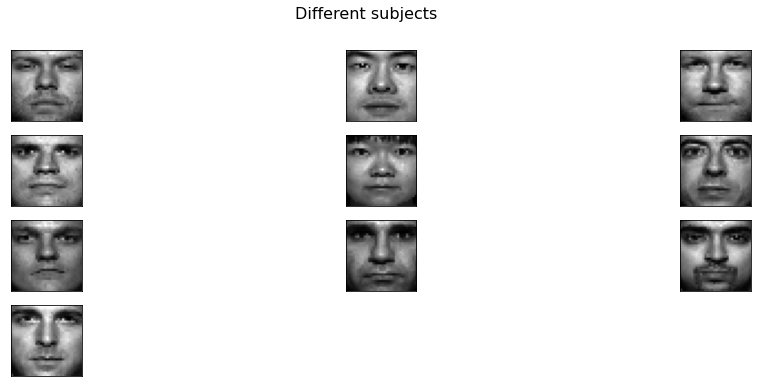

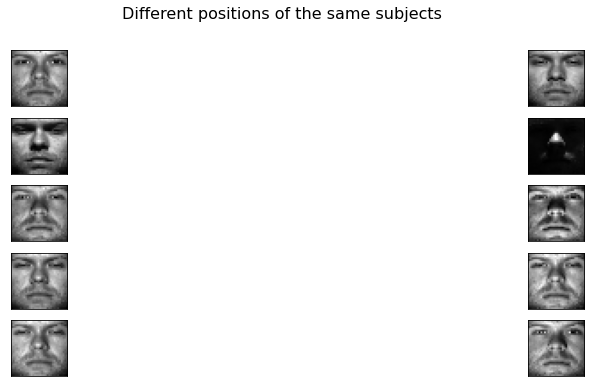

In [6]:
# Plot data      
indexDifferent=np.arange(1,Is*40,Is)     
plotFaces(data,r,c,ncol=3,indeces=indexDifferent[0:10],title='Different subjects')       
indexSame=np.arange(0,10,1)      
plotFaces(data,r,c,ncol=2,indeces=indexSame,title='Different positions of the same subjects')       


In [0]:
# Create train/test split  
trainIdx, testIdx = train_test_split(np.arange(0,data.shape[0],1),test_size=0.3,random_state=1)
Xtest=data[testIdx,:]
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xtrain=data[trainIdx,:]
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering
Id_Train = subjectIndex[trainIdx]; # indeces of the subjects for the training
Id_Test = subjectIndex[testIdx]; # indeces of the subjects for the test

N = Xctrain.shape[0] # N number of training images
M = Xctest.shape[0] # M number of test images 

As first idea, we could simply use the pixel intensities as features. This is basically like using the original data, without dimensionality reducton techniques.

In [8]:
## Use the pixel intensities to find the correct subject for the test images
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Xctrain,Id_Train.ravel())
print('Percentage of correct answer using the pixel intensities is ', NN.score(Xctest,Id_Test))


Percentage of correct answer using the pixel intensities is  0.7324137931034482


# PCA

You will first use PCA. Compute the scores, eigenvectors and eigenvalues of the training set. The eigenvectors represent the basis images and they are usually called *'Eigenfaces'*. Then, project both training and test data onto the eigenvectors that explain 95$\%$ of the variability of the training set. You will obtain two vectors of scores which you will use for evaluating the performance of the algorithm. Use the function *'KNeighborsClassifier'* to test the performance.

**Question:** 

1. Use either the scikit-learn implementation or yours (better!) to compute the PCA for the training data-set. Comment the results.
2. Is it worth it in your opinion to compute PCA ? Why ? Hint: think about the performance in your test set and generalizability, so the number of features...

In [0]:
def pcaLecture(X):
    ''' 
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
              column consists of features.
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of X onto the new basis given by the eigenvactors U
            of the covariance matrix of X. Columns are the principal components.
               
            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)
    
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)
               
            var_explained: percentage of the original variability explained
            by each principal component.
    '''
    
    N=X.shape[0]
    d=X.shape[1]
    Xc=X-np.mean(X,axis=0) # centering
    D2, Uh = LA.svd(Xc)[1:d] # computation of eigenvectors and eigenvalues using SVD
    U=Uh.T
    Y = np.dot(Xc,U) # computation of the scores
    D=D2**2/(N-1) # computation of the eigenvalues
    var_explained = [D[i]/np.sum(D) for i in range(d)] # computation of explained variance
    return Y,U,D,var_explained

PCA
Percentage of correct answer using PCA is  0.713103448275862


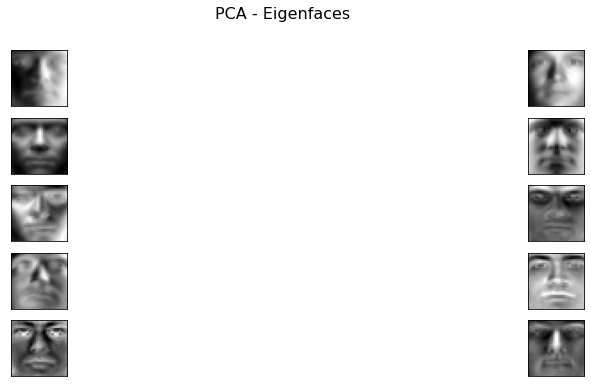

In [10]:
## PCA
print('PCA')
YpcaTrain, UpcaTrain, D, var_explained_pca=pcaLecture(Xctrain)

# Threshold defined as 99% of the variability
Threshold_PCA = 0.99
CumulativePca=np.cumsum(var_explained_pca)
indexPCA=np.argwhere(CumulativePca>Threshold_PCA)
PCAComp=indexPCA[0][0]

# Selection of the eigenvectors 
Yr_train_PCA=YpcaTrain[:,:PCAComp]
Ur_train_PCA=UpcaTrain[:,:PCAComp]

# Computation of the test scores using the eigenvectors computed with the
# training data-set
Yr_test_PCA=np.dot(Xctest,Ur_train_PCA)

# Plot the Eigenfaces
plotFaces(UpcaTrain.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')       

# Score
NN.fit(Yr_train_PCA,Id_Train.ravel())
print('Percentage of correct answer using PCA is ', NN.score(Yr_test_PCA,Id_Test))


--- 

***Response :***

1) The results over the test set is worst than without PCA, we have lose important infomation... <br/>
2) Compute the PCA is not worth it because there is a huge dependence between the different "directions" which are just images of someone. ICA or NNMF would be more useful.

---

# ICA

In the next section tou will evaluate ICA. Every image $x_i$ can be seen as a linear combination of basis images: $x_i=\sum_j c_{ij} b_j$ where $c_{ij}$ is a coefficient and $b_j$ is basis image. ICA can be used in two different ways for face recognition. We can look for a set of statistically independent basis images $b_j$ (first architecture) or for a set of statistically independent coefficients $c_{ij}$ (second architecture).

In the first architecture, we compute $X'=A'S'$, where every row of $X'$ is an image and the columns are pixels. Images are considered as observations and we look for a set of statistically independent basis images contained in the rows of $S'$.

In the second architecture, we transpose the previous setting computing $X''=A''S''$, where every column of $X''$ is an image and rows are pixels. In this case, we consider the pixels as observations and we look for a set of statistically independent coefficients contained in the rows of $S$ and a set of basis images in the columns of $A$.

Instead than using the original training data $X$ as input matrix, we are going to use the eigenvectors (first architecture) or the scores (second architecture) computed with PCA, namely $Y=XL$ (same notation as in the slides of the lecture). In this way, we reduce the computational time since the number of eigenvectors that account for 95\% of the variance of the training images (columns of $L$) is definitely lower than the number of pixels (columns of $X$). If you want, you can of course use the original data but it will take much more time to converge.

For the first architecture we will use $L^T$ as input matrix. In fact, we can notice that the PCA approximation of the matrix $X_{train}$, containing an image in every row, can be written as $\tilde{X}=YL^T$. If we use $L^T$ as input in the ICA algorithm we obtain $L^T=AS$, thus it follows that $\tilde{X}=YW^TS$ (since $A=W^T$). The basis images are contained in the rows of $S$ and the coefficients used for evaluating the performance are instead contained in the rows of $Y_{train}W^T$ for the training set and in $Y_{test}W^T$ for the test set.

For the second architecture, we will instead use $Y^T$ as input matrix. Remember that in the second architecture we want to apply the ICA algorithm to the transpose of $X_{train}$, namely $X^T=AS$. We can notice that, given the PCA transformation $Y=XL$, one can write $AS=Y^T=L^TX^T$ which entails $X^T=LW^TS$. The columns of $LW^T$ contain the basis images whereas the columns of $S$ contain the statistically independent coefficients used to test the performance of the algorithm. For the test set we compute $S_{test}=W_{train}Y_{test}^T$.

**Question:**
 

1.   Implement the two architectures and test their performance. Which one is better ?
2.   Looking at the basis images, in which case do they seem more 'real' ?



In [0]:
#First architecture

#With all the data 
ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(Xctrain)
Aica=ICA.mixing_

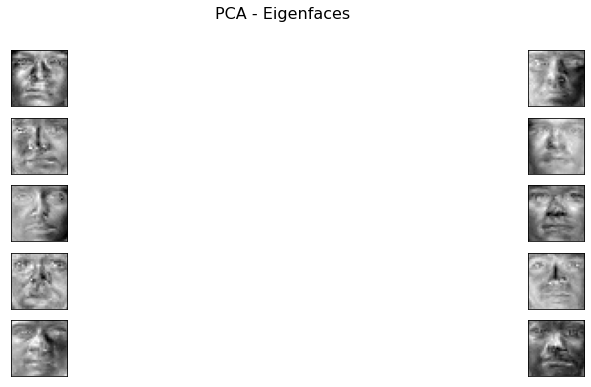

In [31]:
# Plot the Eigenfaces
plotFaces(Aica.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')   

In [33]:
# Computation of the test scores using the eigenvectors computed with the training data-set
Yr_test_ICA=np.dot(Xctest,LA.inv(Aica.T))

# Score
NN.fit(Yica,Id_Train.ravel())
print('Percentage of correct answer using PCA is ', NN.score(Yr_test_ICA,Id_Test))


Percentage of correct answer using PCA is  0.6482758620689655


In [104]:
#Second architecture

#With all the data 
ICA= FastICA(whiten=True, fun='exp', max_iter=2000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(Xctrain.T)
Aica=ICA.mixing_


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [123]:
np.dot(Yica,Aica.T)

array([[ 9.32755505e-17,  1.12284301e-16,  2.80739668e-17, ...,
         1.05257080e-17,  2.50047829e-17,  1.49496381e-17],
       [-1.36191153e-15, -1.63945732e-15, -4.09906550e-16, ...,
        -1.53685324e-16, -3.65093554e-16, -2.18278900e-16],
       [-7.23796508e-16, -8.71299975e-16, -2.17847432e-16, ...,
        -8.16770383e-17, -1.94031281e-16, -1.16005704e-16],
       ...,
       [-1.64918058e-16, -1.98526931e-16, -4.96368454e-17, ...,
        -1.86102287e-17, -4.42103018e-17, -2.64320636e-17],
       [ 3.35092064e-16,  4.03380928e-16,  1.00855620e-16, ...,
         3.78135665e-17,  8.98295886e-17,  5.37065186e-17],
       [ 2.00852041e-16,  2.41783949e-16,  6.04522137e-17, ...,
         2.26652100e-17,  5.38432810e-17,  3.21913439e-17]])

In [124]:
Xctrain.T

array([[ 0.31910517, -0.19854189, -0.21814973, ...,  0.69557576,
        -0.13187522, -0.23775758],
       [ 0.28663904, -0.21140018, -0.22316488, ...,  0.65134492,
        -0.14473351, -0.2466943 ],
       [ 0.39947759, -0.19267927, -0.20052241, ...,  0.67006582,
        -0.14562045, -0.22013025],
       ...,
       [-0.20631073,  0.16231672,  0.55447358, ..., -0.16709504,
         0.13094417,  0.23290496],
       [-0.19861619,  0.20922695,  0.58569754, ..., -0.16332207,
         0.13471714,  0.51903087],
       [-0.19410952,  0.27255715,  0.62157675, ..., -0.16273697,
         0.11961597,  0.55883166]])

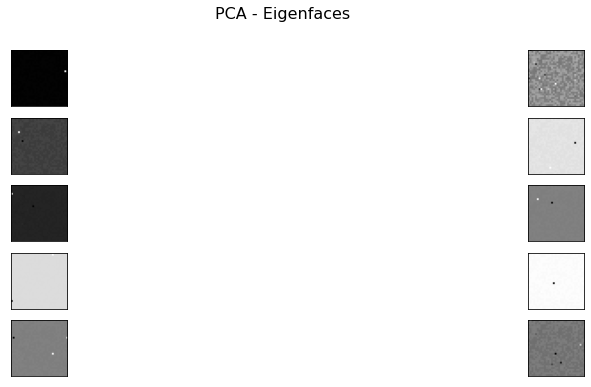

In [126]:
# Plot the Eigenfaces
plotFaces(Yica,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')   

In [127]:
# Computation of the test scores using the eigenvectors computed with the training data-set
score_test_ICA=np.dot(LA.inv(Yica),Xctest.T)

print(score_test_ICA.shape)

# Score
NN.fit(Aica,Id_Train.ravel())
print('Percentage of correct answer using PCA is ', NN.score(score_test_ICA.T,Id_Test))


(1024, 725)
Percentage of correct answer using PCA is  0.03310344827586207


In [0]:
# Second architecture


YpcaTrain, UpcaTrain, D, var_explained_pca=pcaLecture(Xctrain)
Yt=YpcaTrain.T


ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Sica=ICA.fit_transform(Yt)
Aica=ICA.mixing_
W=Aica.T

# Plot the Eigenfaces
plotFaces(np.dot(UpcaTrain,W.T).T,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA - Eigenfaces')    


In [0]:
S_test_ICA=np.dot(W,W.T)

# Score
NN.fit(Yr_train_PCA,Id_Train.ravel())
print('Percentage of correct answer using first ICA is ', NN.score(Yr_test_PCA,Id_Test))

# NNMF

Here you will test Non-negative Matrix factorization. The basis images of the training are in the matrix $W_{train}$ and the scores (or coefficients) to test the performance in $H_{train}$. The test scores are computed as $H_{test}=W_{train}X_{test}$.

**Question**


1.   Implement your own implementation following the lecture slides (62,63,64)
2.   Plot the basis images and compare them with respect to the basis images obtained using PCA and ICA
3.   Test the performance of NNMF




In [0]:
import random as rd

In [0]:
def NNMFLecture(X, r,N_Iter=1000,tolerance=1e-5,plot_evolution=1):
  '''
  Inputs: 
  %           X: is a [dxN] matrix. Every column (x) is an observation and every
  %           row consists of features.
  %
  %           r: size of the matrices W and H
  %
  %           (Optional) N_Iter: maximum number of iterations
  %
  %           (Optional) tolerance: convergence criteria threshold
  %
  %           (Optional) plot_evolution: plot evolution convergence criteria
  %
  % Outputs:
  %           W: is a [d x r] matrix containing the basis images in its
  %           columns
  %           
  %           H: is a [r x N] matrix containing the loadings (h) in its columns
  %           of the linear combination: x=Wh 
  %'
  '''

  d,N=X.shape[0],X.shape[1]
  count=0
  W=np.zeros((d,r))
  H=np.zeros((r,N))
  #Initialization : random 
  for i in range(d):
    for j in range(r):
      W[i][j]=rd.random()
  for i in range(r):
    for j in range(N):
      H[i][j]=rd.random()

  seuil=1
  seuils=[]
  steps=[]

  while ((count<N_Iter) and (seuil>tolerance)):
    W=W*(np.dot(X,H.T))/np.dot(W,np.dot(H,H.T))
    H=H*(np.dot(W.T,X))/np.dot(W.T,np.dot(W,H))
    count+=1
    seuil=np.mean(np.abs((np.dot(W,H)-X)))
    seuils.append(seuil)
    steps.append(count)
  if plot_evolution==1:
    plt.plot(steps,seuils,marker='+')
  


  return W,H

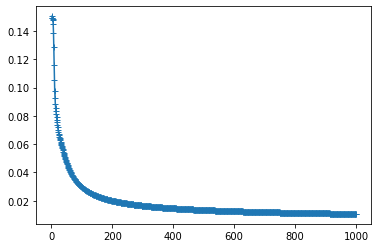

In [57]:
# NNMF

Wtrain,Htrain=NNMFLecture(Xtrain,1024)


In [58]:
np.abs(np.dot(Wtrain,Htrain)-Xtrain)

array([[0.01521634, 0.02864344, 0.01721105, ..., 0.00285515, 0.00717203,
        0.00579206],
       [0.00332332, 0.01451313, 0.00019071, ..., 0.01017333, 0.00072235,
        0.00136311],
       [0.00367637, 0.0063478 , 0.00383617, ..., 0.02552053, 0.03675237,
        0.01053819],
       ...,
       [0.02785085, 0.00609401, 0.00399637, ..., 0.00210917, 0.00031217,
        0.00320429],
       [0.00350838, 0.01165711, 0.01115273, ..., 0.00770994, 0.01876808,
        0.00119169],
       [0.00321436, 0.00620637, 0.00302362, ..., 0.01651454, 0.02049883,
        0.00763817]])

We see that our algorithm converge and that we have Xtrain approximately equals to Wrain.Htrain

Use N random subjects


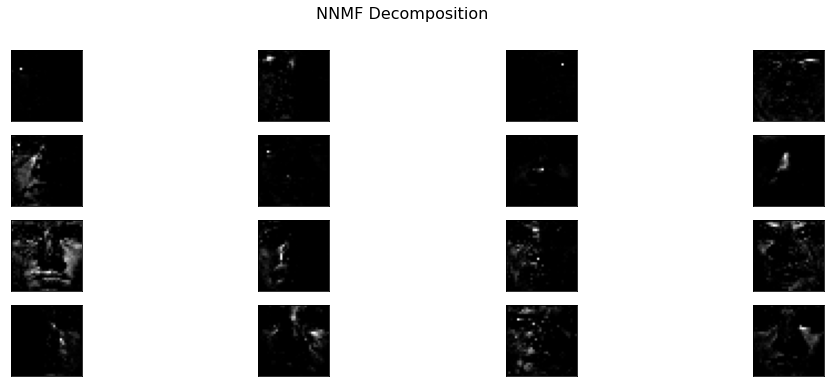

In [99]:
plotFaces(Htrain,r,c,ncol=4,N=16,title='NNMF Decomposition')

The different components found by NNMF seems to be only part of the face contrary to those of PCA which are entire faces. We have sometimes just a nose, or just the half of a face.

We test it on the test set :

In [98]:
Htrain.shape

(1024, 1024)

In [0]:
Wtest=np.dot(Xtest,LA.inv(Htrain))

In [70]:
NN.fit(Wtrain,Id_Train.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [75]:
print('Percentage of correct answer using NNMF is ', NN.score(Wtest,Id_Test))

Percentage of correct answer using NNMF is  0.041379310344827586


This score is very poor compared to the other methods. NNMF works well when the data are part from an addition of data, and that is not the case here.

We test with the implementation of sklearn

In [0]:
from sklearn.decomposition import NMF
model = NMF(n_components=200, init='random', random_state=0)
W = model.fit_transform(Xtrain)
H = model.components_

It is more useful to take less components, here 200, because if we take all the components (1024), it's like decomposing the image over each pixel. It's important to fix a good number of components

Use N random subjects


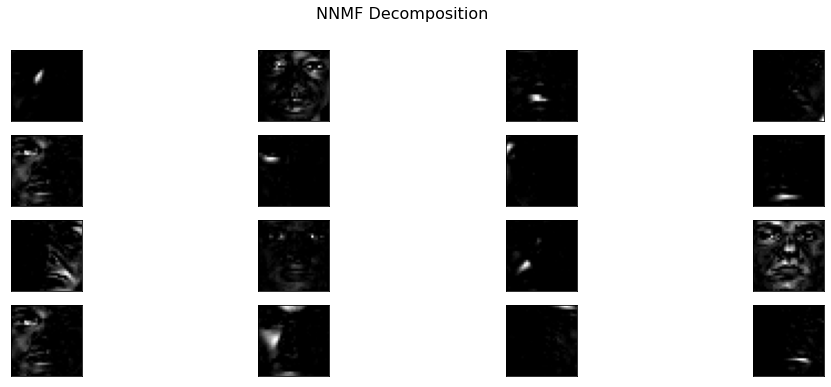

In [102]:
plotFaces(H,r,c,ncol=4,N=16,title='NNMF Decomposition')

In [103]:
Wtest=model.fit_transform(Xtest)
NN.fit(W,Id_Train.ravel())
print('Percentage of correct answer using NNMF is ', NN.score(Wtest,Id_Test))

Percentage of correct answer using NNMF is  0.1820689655172414


The score is better with less components.